# VLLE calculation for binary mixtures with SAFT-$\gamma$-Mie

In this notebook, the VLLE calculations for binary mixtures with ```saftgammamie``` EoS are illustrated.

First, all the needed modules are imported.

- numpy: numerical interface and work with arrays
- matplotlib: to plot results
- sgtpy: package with SAFT-$\gamma$-Mie EoS and phase equilibria functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sgtpy import component, mixture, saftgammamie

Now, pure components are configured and created with the ```component``` function. Then, a mixture is created with them using the ```mixture``` function or by adding (`+`) pure components. The interaction parameters are set up with the ```mixture.saftgammamie``` method. Finally, the ```eos``` object is created with the ```saftgammamie``` function.

The ```eos``` object includes all the necessary methods to compute phase equilibria and interfacial properties using SAFT-$\gamma$-Mie EoS.

For this notebook all calculations are exemplified for a mixture of 2-butanol and water.

In [2]:
butanol2 = component(GC={'CH3':2, 'CH2':1, 'CHOH':1})
water = component(GC={'H2O':1})

# creating mixture with mixture class function
mix = mixture(butanol2, water)
# or creating mixture by adding pure components
mix = butanol2 + water

mix.saftgammamie()
eos = saftgammamie(mix)

## VLLE calculation

Because of degrees of freedom restrictions, this type of calculation is carried at a given temperature or pressure. This type of calculation is carried out with the ```vlleb``` function. This function requires initial guesses for the two liquid phases compositions(```x0``` and ```w0```), the vapor phase composition (```y0```), and the temperature or pressure, depending on the specification.

The ```full_output``` option allows obtaining all the information related to the flash calculation. This includes the volume of the phases and the solution for the fraction of the nonbonded sites of each phase.

Initial guesses can be obtained from tpd minimization (```tpd_min```, ```lle_init``` or ```tpd_minimas```). If any tpd < 0, it means that the global phase is unstable at that it will split into two or more phases. 

In [3]:
# phase equilibria conditions
T = 365.  # K
P = 1.01325e5  # Pa
z = np.array([0.2, 0.8])

In [4]:
from sgtpy.equilibrium import tpd_min
# initial guess for the composition of the trial phase
w0 = np.array([0.1, 0.9])
x0, tpx0 = tpd_min(w0, z, T, P, eos, stateW = 'L', stateZ = 'L')
x0, tpx0

(array([0.03559041, 0.96440959]), -0.016191312656082424)

In [5]:
# initial guess for the composition of the trial phase
w0 = np.array([0.5, 0.5])
w0, tpw0 = tpd_min(w0, z, T, P, eos, stateW = 'L', stateZ = 'L')
w0, tpw0

(array([0.4763473, 0.5236527]), -0.015375904008527286)

In [6]:
y0 = np.array([0.5, 0.5])
y0, tpv0 = tpd_min(w0, z, T, P, eos, stateW = 'V', stateZ = 'L')
y0, tpv0

(array([0.39538751, 0.60461249]), -0.20703703771612636)

Once good initial guesses are available, the binary three-phase equilibria is computed with the ```vlleb``` function as follows.

In [7]:
from sgtpy.equilibrium import vlleb
# initial guesses for aqueous, organic and vapor phase composition obtained from tpd minimization
# calculation at fixed temperature
P0 = 1.01325e5  # Pa
vlleb(x0, w0, y0, P0, T, 'T', eos, full_output=True)

      T: 365.0
      P: 121209.34284737088
  error: 1.1692582758009241e-12
   nfev: 14
      X: array([0.03575514, 0.96424486])
     vx: 2.128005254671421e-05
  Xassx: array([0.09925693, 0.36463567, 0.13197405, 0.13883376])
 statex: 'Liquid'
      W: array([0.47793421, 0.52206579])
     vw: 5.492895005368274e-05
  Xassw: array([0.17939887, 0.55770678, 0.21506411, 0.24435234])
 statew: 'Liquid'
      Y: array([0.39521168, 0.60478832])
     vy: 0.0241048010196862
  Xassy: array([0.97555201, 0.99391855, 0.98293403, 0.97892005])
 statey: 'Vapor'

In [8]:
# initial guesses for aqueous, organic and vapor phase composition obtained from tpd minimization
# calculation at fixed pressure
T0 =  365.  # K
sol = vlleb(x0, w0, y0, T0, P, 'P', eos, full_output=True)
sol

      T: 360.4627056837895
      P: 101325.0
  error: 1.0045792487211278e-12
   nfev: 14
      X: array([0.03688282, 0.96311718])
     vx: 2.127622103935827e-05
  Xassx: array([0.09481754, 0.35546623, 0.12738988, 0.13474036])
 statex: 'Liquid'
      W: array([0.47301928, 0.52698072])
     vw: 5.422869515116268e-05
  Xassw: array([0.16840724, 0.54694615, 0.20424471, 0.23768712])
 statew: 'Liquid'
      Y: array([0.39226543, 0.60773457])
     vy: 0.028581003060714108
  Xassy: array([0.97741748, 0.99441393, 0.98443312, 0.98075068])
 statey: 'Vapor'

## Whole phase diagram calculation

In the following codeblock, the whole phase diagram is computed at constant pressure.

First, the three-phase equilibria computation is carried at the given specification (pressure for this example), then the phase diagram can be separated in a zone for VLE (temperatures higher than computed heterozaeotropic temperature) and another zone where LLE take place (temperatures lower than the computed heterozaeotropic temperature).

It is advised to store the computed volume roots and nonbonded sites fraction, as these can be used in the following iterations to speed up calculations.

In [9]:
from sgtpy.equilibrium import bubbleTy, lle

# three phase equilibria computation
sol = vlleb(x0, w0, y0, T0, P, 'P', eos, full_output=True)
Xhaz,  Whaz, Yhaz, Thaz = sol.X, sol.W, sol.Y, sol.T

n = 30

# VLE zone 1
x1 = np.linspace(0, Xhaz[0], n)
XI = np.array([x1, 1-x1])
YI = np.zeros_like(XI)
TI = np.zeros(n)

vxI = np.zeros(n)
vyI = np.zeros(n)
i = 0
T0 = 373.
sol = bubbleTy(XI[:, i], T0, XI[:, i], P, eos, full_output = True)
YI[:, i], TI[i] = sol.Y, sol.T
vxI[i], vyI[i] = sol.v1, sol.v2
for i in range(1, n):
    sol = bubbleTy(YI[:, i-1], TI[i-1], XI[:, i], P, eos, full_output=True, v0=[vxI[i-1], vyI[i-1]])
    YI[:, i], TI[i] = sol.Y, sol.T
    vxI[i], vyI[i] = sol.v1, sol.v2
    
# VLE zone 2
w1 = np.linspace(Whaz[0], 1, n)
XII = np.array([w1, 1-w1])
YII = np.zeros_like(XII)
TII = np.zeros(n)
vxII = np.zeros(n)
vyII = np.zeros(n)

i = 0
sol = bubbleTy(Yhaz, Thaz, XII[:, i], P, eos, full_output = True)
YII[:, i], TII[i] = sol.Y, sol.T
vxII[i], vyII[i] = sol.v1, sol.v2

for i in range(1, n):
    sol = bubbleTy(YII[:, i-1], TII[i-1], XII[:, i], P, eos, full_output = True, v0=[vxII[i-1], vyII[i-1]])
    YII[:, i], TII[i] = sol.Y, sol.T
    vxII[i], vyII[i] = sol.v1, sol.v2

# LLE calculation
Tll =  np.linspace(Thaz,  290, n)
Xll = np.zeros([2, n])
Wll = np.zeros([2, n])

vxll = np.zeros(n)
vwll = np.zeros(n)

i = 0 
Z = (Xhaz+Whaz)/2
sol = lle(Xhaz, Whaz, Z, Tll[i], P, eos, full_output=True)
Xll[:, i], Wll[:, i] = sol.X
vxll[i], vwll[i] = sol.v

for i in range(1, n):
    Z = (Xll[:, i-1] + Wll[:, i-1])/2
    sol = lle(Xll[:, i-1], Wll[:, i-1], Z, Tll[i], P, eos, full_output=True, v0=[vxll[i-1], vwll[i-1]])
    Xll[:, i], Wll[:, i] = sol.X
    vxll[i], vwll[i] = sol.v
    # print(i, sol.error_outer, sol.error_inner, sol.tetha, sol.iter)

The results are plotted bellow.

(0.0, 1.0)

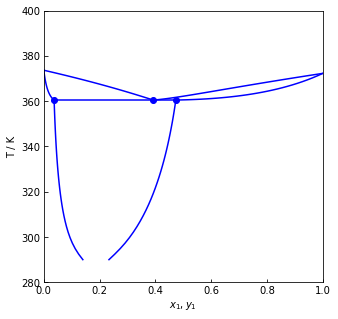

In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(XI[0], TI, color = 'b')
ax.plot(YI[0], TI, color = 'b')

ax.plot(XII[0], TII, color = 'b')
ax.plot(YII[0], TII, color = 'b')

ax.plot(Xll[0], Tll, color = 'b')
ax.plot(Wll[0], Tll, color = 'b')

ax.plot([Xhaz[0], Yhaz[0], Whaz[0]], [Thaz, Thaz, Thaz], 'o-', color = 'b')


ax.tick_params(direction='in')
ax.set_xlabel('$x_1, y_1$')
ax.set_ylabel('T / K')
ax.set_ylim([280, 400])
ax.set_xlim([0, 1])
# fig.savefig('vlle-binary.pdf')

For further information of any of these functions just run: ```function?```